In [4]:
########## Importing Libraries ##############
import re
import string
import warnings
import pandas as pd
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from copy import deepcopy
warnings.filterwarnings(action="ignore")

############ For NLP ###########################
import spacy
from nltk.util import ngrams
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


########## Visualization #######################
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

############## For Machine Learning #############
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

################ For Deep Learning ###############
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel
from transformers import BertTokenizer
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup



### Data Scrubbing

In [5]:
# load the dataset 
df = pd.read_csv(
    'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/Dataset/ecommerceDataset.csv', 
    names = ['label', 'description']
)

# switch columns 
df = df[['description', 'label']]

In [6]:
# Dropping duplicate observations
df.drop_duplicates(inplace = True)

# shuffle the dataset as labels are not shuffled 
df = shuffle(df)

# reset index after shuffeling 
df.reset_index(drop=True, inplace=True)


In [7]:
df.head(3)

,description,label
0,Biba Girls' Skirt,Clothing & Accessories
1,"Veirdo Men's Cotton Tshirt ""Go weird with veir...",Clothing & Accessories
2,INDISWAN Stainless Steel Bathroom Towel Napkin...,Household


<p style="text-align: center;">Checking for Null Values</p>

In [8]:
# Check for null values
null = df.isnull().sum().to_dict()

for k, v in null.items():
    print(f"Column : {k} has {v} null values." )
    
print(f"Before dropping null, dataset has: {df.shape[0]} rows.")

Column : description has 1 null values.
Column : label has 0 null values.
Before dropping null, dataset has: 27803 rows.


In [9]:
# drop the null values 
df = df.dropna(subset=['description'])
print(f"After dropping null, dataset has: {df.shape[0]} rows.")

After dropping null, dataset has: 27802 rows.


### EDA

<p style="text-align: center;">Text Length Analysis</p>

In [10]:
# Calculate the length of each text as new column
df['text_length'] = df['description'].apply(len)

# Get the unique categories
categories = df['label'].unique()

In [11]:
# plot the histogram of length in each category.
fig = go.Figure()
for category in categories:
    fig.add_trace(go.Histogram(x=df[df['label'] == category]['text_length'], 
                               name=category))

# Update layout for better visualization
fig.update_layout(barmode='stack',
                  xaxis_title='Text Length',
                  yaxis_title='Count',
                  title='Histogram of Text Length in Each Category',
                  autosize=False,
                  width=1000,
                  height=600)

fig.show()

Seems like we have some descriptions with extreme lengths, we will consider these lengths as extreme outliers. Lets do box and whisker plot per category to get better idea of length distrubution.

In [12]:
fig = px.box(df, x='label', y='text_length', color='label')

# Update layout for better visualization
fig.update_layout(title='Box Plot of Text Length for Each Category',
                  autosize=False,
                  width=1000,
                  height=600)

fig.show()

Now, we will apply IQR technique to handle these extreme text lengths.

In [13]:
# Method to remove extreme length by IQR techinique based on text length.
def remove_outliers_by_iqr(group):
    Q1 = group['text_length'].quantile(0.25)
    Q3 = group['text_length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['text_length'] >= lower_bound) & (group['text_length'] <= upper_bound)]

# For each category, remove extreme length based on IQR
df_filtered = df.groupby('label').apply(remove_outliers_by_iqr).reset_index(drop=True)

In [14]:
# Create a histogram for each category
fig = go.Figure()
for category in categories:
    fig.add_trace(go.Histogram(x=df_filtered[df_filtered['label'] == category]['text_length'], 
                               name=category))

# Update layout for better visualization
fig.update_layout(barmode='stack',
                  xaxis_title='Text Length',
                  yaxis_title='Count',
                  title='Histogram of Text Length in Each Category',
                  autosize=False,
                  width=1000,
                  height=600)

fig.show()

<p style="text-align: center;">Number of samples per category.</p>

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# some minimal colors
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
            '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

def cat_summary_with_graph(dataframe, col_name):

    # Create subplots for bar abd pie chart.
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Records per class.', 'Percentage of classes.'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])
    
    # Code for count plot in plotly.
    value_counts = dataframe[col_name].value_counts()
    fig.add_trace(go.Bar(y=value_counts.values.tolist(),
                         x=[str(i) for i in value_counts.index],
                         text=value_counts.values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC', width=1))),
                  row=1, col=1)
    
    # Code for pie chart in plotly.
    fig.add_trace(go.Pie(labels=value_counts.keys(),
                         values=value_counts.values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)
    
    # Update layout
    fig.update_layout(title={
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    
    fig.show()


# Call the function
cat_summary_with_graph(df_filtered, 'label')


<p style="text-align: center;">NGrams Analysis.</p>

In [16]:

from typing import Iterable

class GetNgramsFrequency:
    """A class to generate and visualize n-gram frequency distributions from the given corpus.
    """
    def __init__(self, text_list : Iterable) -> None:
        """
        Initialize the class with a list of text documents.

        Args:
            text_list (Iterable): A list of text documents.
        """
        self.text_list = text_list
        self.unigram = None
        self.bigram = None
        self.trigram = None
        
    def find_n_gram(self, size, top_n)->pd.DataFrame:
        """
        Get the most frequent n-grams of a given size in the text documents.
        Args:
            size (int): The size of the n-grams.(e.g., 1 for unigrams, 2 for bigrams, 3 for trigrams).
            top_n (int): The number of top n-grams.
        Returns:
            pd.DataFrame: A DataFrame with top n-grams and their counts.
        """
        ngrams_all = []
        for document in self.text_list:
            tokens = document.split()
            if len(tokens) <= size:
                continue
            else:
                output = list(ngrams(tokens, size))
            for ngram in output:
                ngrams_all.append(" ".join(ngram))
        cnt_ngram = Counter()
        for word in ngrams_all:
            cnt_ngram[word] += 1
        df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
        df = df.rename(columns={'index':'words', 0:'count'})
        df = df.sort_values(by='count', ascending=False)
        df = df.head(top_n)
        df = df.sort_values(by='count')
        return(df)
    

    def generate_n_grams(self, top_n)-> None:
        """
        Find and store the most frequent unigrams, bigrams, and trigrams.
        Args:
            top_n (int): The number of top n-grams for each n-gram size.
        """
        self.unigram = self.find_n_gram(size=1, top_n=top_n)
        self.bigram = self.find_n_gram(size=2, top_n=top_n)
        self.trigram = self.find_n_gram(size=3, top_n=top_n)
        
        
    def plot_distribution(self)->None:
        """Plots the frequency distribution of unigrams, bigrams, and trigrams.
        """

        fig = make_subplots(rows=1, cols=3, subplot_titles=('Unigrams', 'Bigrams', 'Trigrams'))
        fig.add_trace(go.Bar(x=self.unigram['count'], y=self.unigram['words'], orientation='h', marker=dict(opacity=0.5)), row=1, col=1)
        fig.add_trace(go.Bar(x=self.bigram['count'], y=self.bigram['words'], orientation='h', marker=dict(opacity=0.5)), row=1, col=2)
        fig.add_trace(go.Bar(x=self.trigram['count'], y=self.trigram['words'], orientation='h', marker=dict(opacity=0.5)), row=1, col=3)
        fig.update_layout(height=700, width=1500, showlegend=False)
        fig.update_xaxes(title_text='Count', row=1, col=1)
        fig.update_xaxes(title_text='Count', row=1, col=2)
        fig.update_xaxes(title_text='Count', row=1, col=3)
        fig.show()

In [17]:
# initialize the GetNgramsFrequency object 
n_gram_analyzer = GetNgramsFrequency(text_list=df_filtered["description"])

# find top n n-grams
n_gram_analyzer.generate_n_grams(top_n=10)

# plot the frequncy distribution
n_gram_analyzer.plot_distribution()

### Text Cleaning

Let's define our custom tokenizer. 

In [18]:
class Tokenizer:
    """tokenize text into words using a regular expression-based tokenizer
    """
    def __init__(self) -> None:
        self.tokenizer = RegexpTokenizer("[\w']+")

    def word_tokenizer(self, text) -> Iterable:
        """Tokenizes the input text into words

        Args:
            text (str): The text to be tokenized.

        Returns:
            Iterable: A list of tokens (words).
        """
        return self.tokenizer.tokenize(text)


In [19]:
class TextCleaner(Tokenizer):
    """A class for cleaning text data, extending the Tokenizer
    """
    def __init__(self) -> None:
        """Initialize the TextCleaner class by loading the acronyms and contractions dictionaries.
        """
        super().__init__()

        # the acronyms url
        self._acronyms_url = "https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json"

        # link to data where contractios list is present
        self._contractions_url = "https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json"

        # load the acronym dict
        self._acronyms_dict = self.load_acronym()
        # load acronym list
        self._acronym_list = list(self._acronyms_dict.keys())

        # load the contractions dict
        self._contractions_dict = self.load_contractions()
        # load contractions list
        self._contractions_list = list(self._contractions_dict.keys())

    def load_acronym(self) -> pd.Series:
        """Loads the acronyms dictionary from the specified URL.
        Returns:
             pd.Series: Retrun dictionary as pandas series.
        """
        return pd.read_json(self._acronyms_url, typ="series")

    def load_contractions(self):
        """Loads the contractions dictionary from the specified URL.
        Returns:
             pd.Series: Retrun dictionary as pandas series.
        """
        return pd.read_json(self._contractions_url, typ="series")

    # Converting to lowercase
    def convert_to_lowercase(self, text):
        return text.lower()

    # remove whitespace from the text
    def remove_whitespace(self, text):
        return text.strip()

    # Removing punctuations from the given string
    def remove_punctuation(self, text):
        # get all the punctuations
        punct_str = string.punctuation

        # the apostrophe will be remove using contraction.
        punct_str = punct_str.replace("'", "")
        return text.translate(str.maketrans("", "", punct_str))

    # Remove any HTML if present in the text.
    def remove_html(self, text):
        html = re.compile(r"<.*?>")
        return html.sub(r"", text)

    # Remove URLs
    def remove_http(self, text):
        http = "https?://\S+|www\.\S+"  # matching strings beginning with http (but not just "http")
        pattern = r"({})".format(http)  # creating pattern
        return re.sub(pattern, "", text)

    # Remove any Emojis present in the text.
    def remove_emoji(self, text):
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+",
            flags=re.UNICODE,
        )
        return emoji_pattern.sub(r"", text)

    def convert_acronyms(self, text):
        words = []
        for word in self.word_tokenizer(text):
            if word in self._acronym_list:
                words = words + self._acronyms_dict[word].split()
            else:
                words = words + word.split()

        text_converted = " ".join(words)
        return text_converted

    def convert_contractions(self, text):
        words = []
        for word in self.word_tokenizer(text):
            if word in self._contractions_list:
                words = words + self._contractions_dict[word].split()
            else:
                words = words + word.split()

        text_converted = " ".join(words)
        return text_converted

    def __call__(self, text):
        """
        Cleans the input text.
        Applies a series of preprocessing steps, including:
        converting to lowercase, removing whitespace, punctuation, HTML tags, URLs, and emojis,
        and converting acronyms and contractions to their expanded forms.
        Args:
            text (str): The text to be cleaned.

        Returns:
            str: The cleaned text.
        """
        text = self.convert_to_lowercase(text=text)
        text = self.remove_whitespace(text=text)
        text = self.remove_punctuation(text=text)
        text = self.remove_html(text=text)
        text = self.remove_http(text=text)
        text = self.remove_emoji(text=text)
        text = self.convert_acronyms(text=text)
        text = self.convert_contractions(text=text)

        return text

In [20]:
# initialize the text cleaner 
text_cleaner = TextCleaner()


# apply the text cleaner to the descriptions 
df_filtered["cleaned_description"] = df_filtered["description"].apply(text_cleaner)

Text Processing and Normalization.

In [21]:
prepositions = [
    "about",
    "above",
    "across",
    "after",
    "against",
    "among",
    "around",
    "at",
    "before",
    "behind",
    "below",
    "beside",
    "between",
    "by",
    "down",
    "during",
    "for",
    "from",
    "in",
    "inside",
    "into",
    "near",
    "of",
    "off",
    "on",
    "out",
    "over",
    "through",
    "to",
    "toward",
    "under",
    "up",
    "with",
]
prepositions_less_common = [
    "aboard",
    "along",
    "amid",
    "as",
    "beneath",
    "beyond",
    "but",
    "concerning",
    "considering",
    "despite",
    "except",
    "following",
    "like",
    "minus",
    "onto",
    "outside",
    "per",
    "plus",
    "regarding",
    "round",
    "since",
    "than",
    "till",
    "underneath",
    "unlike",
    "until",
    "upon",
    "versus",
    "via",
    "within",
    "without",
]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = [
    "both",
    "and",
    "either",
    "or",
    "neither",
    "nor",
    "not",
    "only",
    "but",
    "whether",
    "or",
]
subordinating_conjunctions = [
    "after",
    "although",
    "as",
    "as if",
    "as long as",
    "as much as",
    "as soon as",
    "as though",
    "because",
    "before",
    "by the time",
    "even if",
    "even though",
    "if",
    "in order that",
    "in case",
    "in the event that",
    "lest",
    "now that",
    "once",
    "only",
    "only if",
    "provided that",
    "since",
    "so",
    "supposing",
    "that",
    "than",
    "though",
    "till",
    "unless",
    "until",
    "when",
    "whenever",
    "where",
    "whereas",
    "wherever",
    "whether or not",
    "while",
]


class TextPreprocess(Tokenizer):

    def __init__(self) -> None:
        super().__init__()
        # initialize and update the stop words
        self.stopwords = stopwords.words("english") + [
            "among",
            "onto",
            "shall",
            "thrice",
            "thus",
            "twice",
            "unto",
            "us",
            "would",
        ]

        # spell checker
        self.spell = SpellChecker()

        # stemmer object
        self.stemmer = PorterStemmer()

        # spacy lemmatizer object
        self.spacy_lemmatizer = spacy.load("en_core_web_sm", disable=["parser", "ner"])

        # remove additional stop words
        self.additional_stop_words = (
            prepositions
            + prepositions_less_common
            + coordinating_conjunctions
            + correlative_conjunctions
        )

    def remove_stopwords(self, word_list):
        return [word for word in word_list if word not in self.stopwords]

    def pyspellchecker(self, word_list):
        unknown_words = self.spell.unknown(word_list)
        return [self.spell.correction(word) if word in unknown_words else word for word in word_list]

    def porter_stemmer(self, word_list):
        return [self.stemmer.stem(word) for word in word_list if word is not None]


    def lemmatizer(self, word_list):
        return [token.lemma_ for token in self.spacy_lemmatizer(" ".join(word_list))]

    def remove_additional_stopwords(self, word_list):
        return [word for word in word_list if word not in self.additional_stop_words]

    def __call__(self, text):
        try:
            text = text.strip()
            word_list = self.word_tokenizer(text)
            word_list = self.remove_stopwords(word_list)
            # word_list = self.pyspellchecker(word_list)
            word_list = self.porter_stemmer(word_list)
            word_list = self.lemmatizer(word_list)
            word_list = self.remove_additional_stopwords(word_list)

            return " ".join(word_list)
        
        except Exception as e:
            raise e


In [22]:
from tqdm.auto import tqdm

# Initialize the text processor
text_processor = TextPreprocess()

cleaned = []

for text in tqdm(df_filtered["cleaned_description"]):
    cleaned.append(text_processor(text=text))


  0%|          | 0/26511 [00:00<?, ?it/s]

In [23]:
# put the final text in the dataframe
df_filtered["text"] = cleaned

# remove all the intermediate results to save memory 
del df_filtered["cleaned_description"]


del df_filtered["description"]


del df_filtered["text_length"]

In [24]:
df_filtered.head()

,label,text
0,Books,man mar woman venu harper audio author john gr...
1,Books,indra nooyi biographi author authorannapoorna ...
2,Books,foundat periodont dental hygienist point lippi...
3,Books,saco waterproof exercis sport belt expand stor...
4,Books,law human natur export tpb review machiavelli ...


In [25]:
# create a copy of data for deep learning task 
df_dl = deepcopy(df_filtered)

### Text Vectorization

#### BOW

In [26]:
# initialize bow vectorizer where whe want 1-2 n-gram which are repeated
# atleast twice where max_df=0.9 means words occurring in more than 90% of the documents will be ignored

bow_vectorizer = CountVectorizer(max_df=0.9,min_df=2,ngram_range=(1,3))


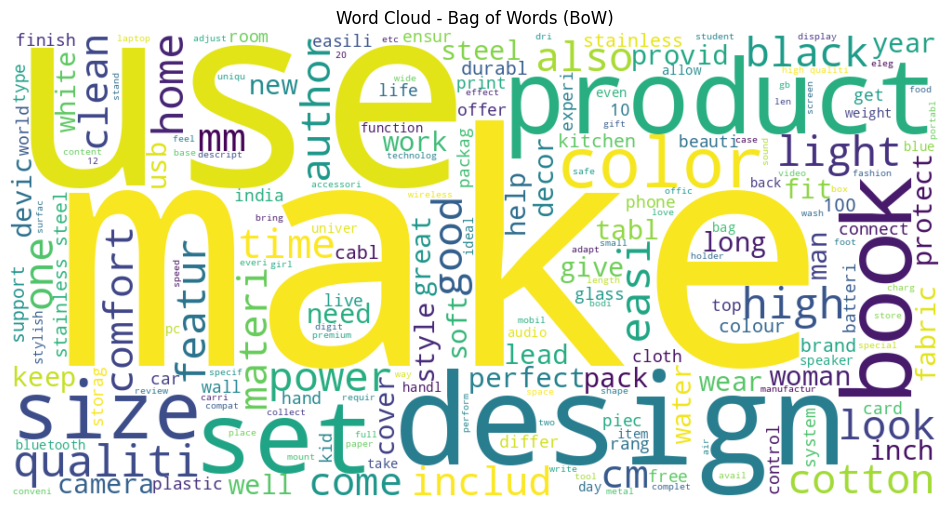

In [27]:

# fit the bag of words on given text
X_bow = bow_vectorizer.fit_transform(df_filtered['text'])

# Get the vocabulary (word to index mapping)
vocab = bow_vectorizer.vocabulary_

# Preparation for the word cloud
reverse_vocab = {idx: word for word, idx in vocab.items()}
word_counts = X_bow.sum(axis=0)
word_freq = {reverse_vocab[idx]: word_counts[0, idx] for idx in range(len(vocab))}
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(word_freq)
# Show the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bag of Words (BoW)')
plt.show()

#### TF-IDF

In [28]:
# initialize tf-idf
# vectorizer where whe want 1-2 n-gram which are repeated
# atleast twice where max_df=0.9 means words occurring in more than 90% of the documents will be ignored

tf_idf = TfidfVectorizer(min_df=2,max_df=0.90,ngram_range=(1,3))

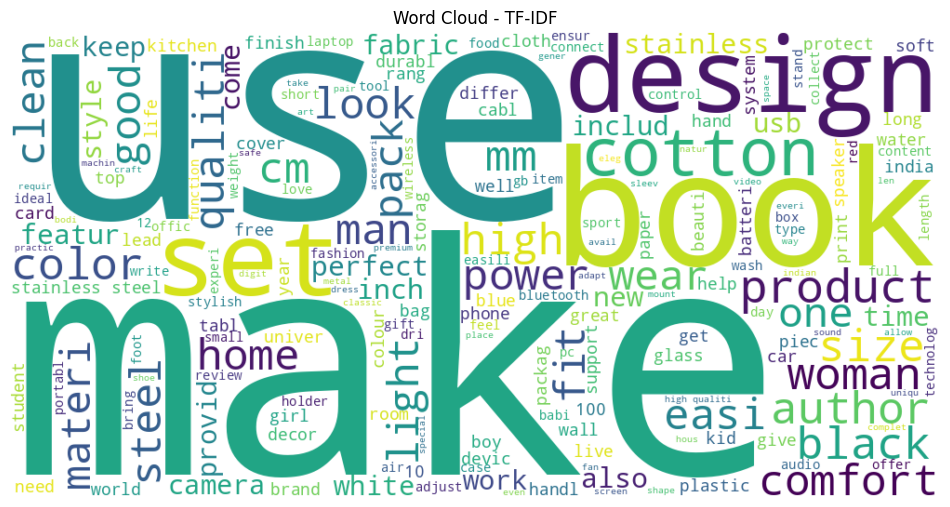

In [29]:
# fit the bag of words on given text
X_tfidf = tf_idf.fit_transform(df_filtered['text'])

# Get the vocabulary (word to index mapping)
vocab = tf_idf.vocabulary_

# Preparation for the word cloud
reverse_vocab = {idx: word for word, idx in vocab.items()}
word_counts = X_tfidf.sum(axis=0)
word_freq = {reverse_vocab[idx]: word_counts[0, idx] for idx in range(len(vocab))}
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(word_freq)
# Show the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - TF-IDF')
plt.show()

### Modelling

Encoding Lables of the dataset.

In [30]:
# initialize the label encoder
le = LabelEncoder()

# apply on the data
df_filtered['label'] = le.fit_transform(df_filtered['label'])

# reshuffle
df_filtered = shuffle(df_filtered)

# reset index
df_filtered.reset_index(drop = True, inplace = True)

print(f"Final data for training: ")
df_filtered.tail(3)

Final data for training: 


,label,text
26508,2,sound boss combo 2din bluetooth car video play...
26509,0,neonat pediatr respiratori care review complet...
26510,0,windsurf techniqu tactic train crowood sport guid


#### Machine Learning

In [31]:
# Split the data for train test : 
X = df_filtered['text'] 
y = df_filtered['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)

**Bag of Words + MultinomialNB**

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1736
           1       0.98      0.96      0.97      1617
           2       0.93      0.93      0.93      1502
           3       0.93      0.96      0.95      3099

    accuracy                           0.95      7954
   macro avg       0.95      0.94      0.95      7954
weighted avg       0.95      0.95      0.95      7954



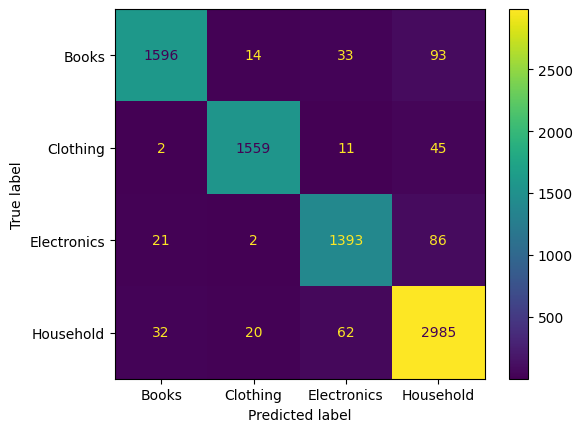

In [32]:
# create pipeline with bow+multinominalnb
pipe_bow_nb = Pipeline([('vectorizer', bow_vectorizer),
                    ('classifier', MultinomialNB())])

# fit on the data
pipe_bow_nb.fit(X_train,y_train)

# get the predictions
y_pred_bow_nb = pipe_bow_nb.predict(X_test)

# print the classification report 

print(classification_report(y_test,y_pred_bow_nb))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_bow_nb),display_labels=['Books','Clothing','Electronics','Household']).plot()

**Bag of Words + RandomForestClassifier**

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1736
           1       0.98      0.95      0.96      1617
           2       0.95      0.84      0.89      1502
           3       0.90      0.95      0.92      3099

    accuracy                           0.93      7954
   macro avg       0.93      0.92      0.93      7954
weighted avg       0.93      0.93      0.93      7954



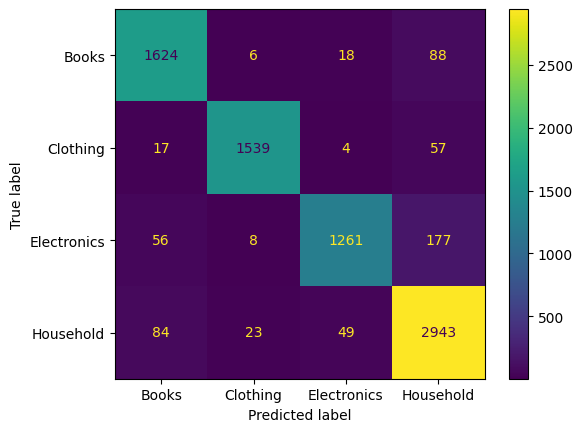

In [33]:
# create pipeline with bow+RandomForestClassifier
pipe_bow_rf = Pipeline([('vectorizer', bow_vectorizer),
                    ('classifier', RandomForestClassifier())])

# fit on the data
pipe_bow_rf.fit(X_train,y_train)

# get the predictions
y_pred_bow_rf = pipe_bow_rf.predict(X_test)

# print the classification report 

print(classification_report(y_test,y_pred_bow_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_bow_rf),display_labels=['Books','Clothing','Electronics','Household']).plot()

**TF-IDF + MultinomialNB**

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1736
           1       0.99      0.92      0.95      1617
           2       0.96      0.84      0.90      1502
           3       0.86      0.98      0.92      3099

    accuracy                           0.92      7954
   macro avg       0.95      0.91      0.93      7954
weighted avg       0.93      0.92      0.92      7954



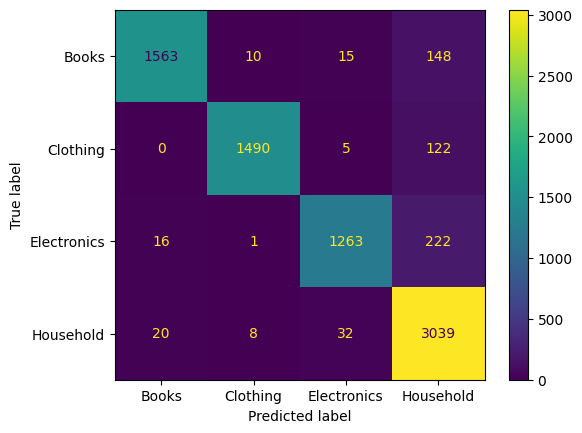

In [34]:
# create pipeline with Tfidf+multinominalnb
pipe_tfidf_nb = Pipeline([('vectorizer', tf_idf),
                    ('classifier', MultinomialNB())])

# fit on the data
pipe_tfidf_nb.fit(X_train,y_train)

# get the predictions
y_pred_tfidf_nb = pipe_tfidf_nb.predict(X_test)

# print the classification report 

print(classification_report(y_test,y_pred_tfidf_nb))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_tfidf_nb),display_labels=['Books','Clothing','Electronics','Household']).plot()

**TFIDF + RandomForestClassifier**

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1736
           1       0.98      0.95      0.96      1617
           2       0.95      0.84      0.89      1502
           3       0.90      0.95      0.92      3099

    accuracy                           0.93      7954
   macro avg       0.94      0.92      0.93      7954
weighted avg       0.93      0.93      0.93      7954



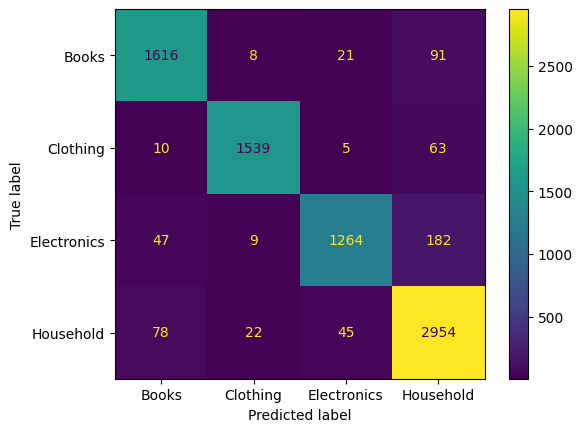

In [35]:
# create pipeline with bow+RF
pipe_rf_knn = Pipeline([('vectorizer', tf_idf),
                    ('classifier', RandomForestClassifier())])

# fit on the data
pipe_rf_knn.fit(X_train,y_train)

# get the predictions
y_pred_bow_rf = pipe_rf_knn.predict(X_test)

# print the classification report 

print(classification_report(y_test,y_pred_bow_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_bow_rf),display_labels=['Books','Clothing','Electronics','Household']).plot()

#### Deep learning

In [36]:
class TensorDataLoader(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [37]:
class PrepareDataset:
    
    def __init__(self, dataframe, text_column_name : str, labels_column_name: str, encoding : bool = False, split : float = 0.75) -> None:
        self.df = dataframe
        
        self.text_column_name = text_column_name
        self.labels_column_name = labels_column_name
        
        if encoding:
            self.convert_label()
            
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        
        self.split = split
        
        self.unique_labels = self.df[self.labels_column_name].nunique()
    
    def convert_label(self):
        unique = self.df[self.labels_column_name].unique()
        map_value = {v: i for i, v in enumerate(unique)}
        self.df[f"{self.labels_column_name}"] = self.df[self.labels_column_name].map(map_value)


    def get_input_id_attention_mask(self, sentence):
        tokens = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )
    
        return tokens['input_ids'].squeeze(), tokens['attention_mask'].squeeze()
    
    
    def get_data_loader(self):
        
        ids = torch.zeros(((len(self.df), 512)), dtype=torch.long)
        masks = torch.zeros(((len(self.df), 512)), dtype=torch.long)

        # Iterate over each text in the 'text' column of the DataFrame
        for i, txt in enumerate(self.df[self.text_column_name]):
            # Tokenize the current text using the tokenize function
            input_ids, attention_masks = self.get_input_id_attention_mask(txt)
            
            # Assign the tokenized input IDs to the corresponding row in the ids tensor
            ids[i,:]=input_ids
            
            # Assign the attention masks to the corresponding row in the masks tensor
            masks[i,:]=attention_masks
            
        arr = self.df[self.labels_column_name].values
        labels = torch.zeros((arr.size, arr.max()+1), dtype=torch.float)
        labels[torch.arange(arr.size), arr] = 1
        
        dataset = TensorDataLoader(ids, masks, labels)
        
        train_size = int(len(dataset) * self.split)
        test_size = len(dataset) - train_size

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        
        return train_dataset, test_dataset

In [38]:
bert_data_loader = PrepareDataset(dataframe=df_dl,
                                  text_column_name="text",
                                  labels_column_name="label",
                                  encoding=True)

# initialize the data loader, prepare dataset using PrepareDataset class
train_dataset, test_dataset = bert_data_loader.get_data_loader()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [39]:

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
seed = 42
torch.manual_seed(seed)


# Define NN Architecture
class ClassificationModel(nn.Module):
    def __init__(self, bert, n_lables : int):
        """
        Initialize the sentiment classifier model with BERT.
        
        Parameters:
        - bert (BertModel): Pretrained BERT model.
        """
        super(ClassificationModel, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.25)
        self.fc = nn.Linear(bert.config.hidden_size, n_lables)
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass for the sentiment classifier.
        
        Parameters:
        - input_ids (torch.Tensor): Input IDs tensor.
        - attention_mask (torch.Tensor): Attention mask tensor.
        
        Returns:
        - torch.Tensor: Output logits.
        """
        # Pass the inputs through the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use the pooled output from BERT
        pooled_output = outputs.pooler_output
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Pass through the fully connected layer to get logits
        logits = self.fc(pooled_output)
        
        return logits

In [41]:
# Initialize Bert Architecture
bert = BertModel.from_pretrained('bert-base-cased')

# Initialize NN Architecture
BertClassifier = ClassificationModel(bert,bert_data_loader.unique_labels)

# set the unfreeze layer 10 or layer 11
for name, param in BertClassifier.bert.named_parameters():
    if 'layer.11' in name or 'layer.10' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# if multiple devices, convert the model into model parallel.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    BertClassifier = nn.DataParallel(BertClassifier)
    BertClassifier.to(device)    
    
else:
    # if not, just convert the model into device
    BertClassifier.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Device: cuda


In [42]:
#No of Epochs
epochs = 10

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, BertClassifier.parameters()), lr=2e-5)

# Define Scheduler with total seteps 
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [43]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []

all_epoch_preds, all_epoch_labels = [], []

for epoch in range(epochs):
    # Set the model to training mode
    BertClassifier.train()
    total_loss, total_correct = 0, 0
    total_samples = 0  # Initialize total samples for train

    # Create a progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    # Iterate over the training batches
    for i, batch in enumerate(train_loader_tqdm):
        # Zero the gradients
        optimizer.zero_grad()

        # Move the batch data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)

        # Forward pass through the model
        outputs = BertClassifier(input_ids, attention_mask)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Update the total loss, correct predictions, and total samples
        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += len(batch["input_ids"])

        # Update the progress bar with the current loss and accuracy
        train_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}",
                                        "acc": f"{(outputs.argmax(dim=1) == labels).float().mean().item() * 100:.2f}%"})

    # Update the learning rate scheduler
    scheduler.step()

    # Calculate the average training loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_correct / total_samples

    # Append the training loss and accuracy to the lists
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # Print the training loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc * 100:.2f}%")

    # Set the model to evaluation mode
    BertClassifier.eval()
    total_test_loss, total_test_correct = 0, 0
    total_test_samples = 0  # Initialize total samples for test
    all_preds = []
    all_labels = []

    # Create a progress bar for the test loop
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    # Disable gradient calculation for the test loop
    with torch.no_grad():
        # Iterate over the test batches
        for i, batch in enumerate(test_loader_tqdm):
            # Move the batch data to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            # Forward pass through the model
            outputs = BertClassifier(input_ids, attention_mask)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the total validation loss, correct predictions, and total samples
            total_test_loss += loss.item()
            total_test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_test_samples += len(batch["input_ids"])

            # Collect predictions and true labels
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update the progress bar with the current validation loss and accuracy
            test_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}",
                                           "acc": f"{(outputs.argmax(dim=1) == labels).float().mean().item() * 100:.2f}%"})

    # Calculate the average validation loss and accuracy
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_acc = total_test_correct / total_test_samples

    # Append the validation loss and accuracy to the lists
    test_loss.append(avg_test_loss)
    test_acc.append(avg_test_acc)

    # Append epoch predictions and labels to the lists
    all_epoch_preds.extend(all_preds)
    all_epoch_labels.extend(all_labels)

    # Print the validation loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.2f}%")

Epoch 1/2:   0%|          | 0/622 [00:00<?, ?batch/s]

Epoch 1/2, Training Loss: 0.4994, Training Accuracy: 82.83%


Epoch 1/2:   0%|          | 0/208 [00:00<?, ?batch/s]

Epoch 1/2, Test Loss: 0.2649, Test Accuracy: 92.26%


Epoch 2/2:   0%|          | 0/622 [00:00<?, ?batch/s]

Epoch 2/2, Training Loss: 0.2672, Training Accuracy: 92.21%


Epoch 2/2:   0%|          | 0/208 [00:00<?, ?batch/s]

Epoch 2/2, Test Loss: 0.2392, Test Accuracy: 92.83%


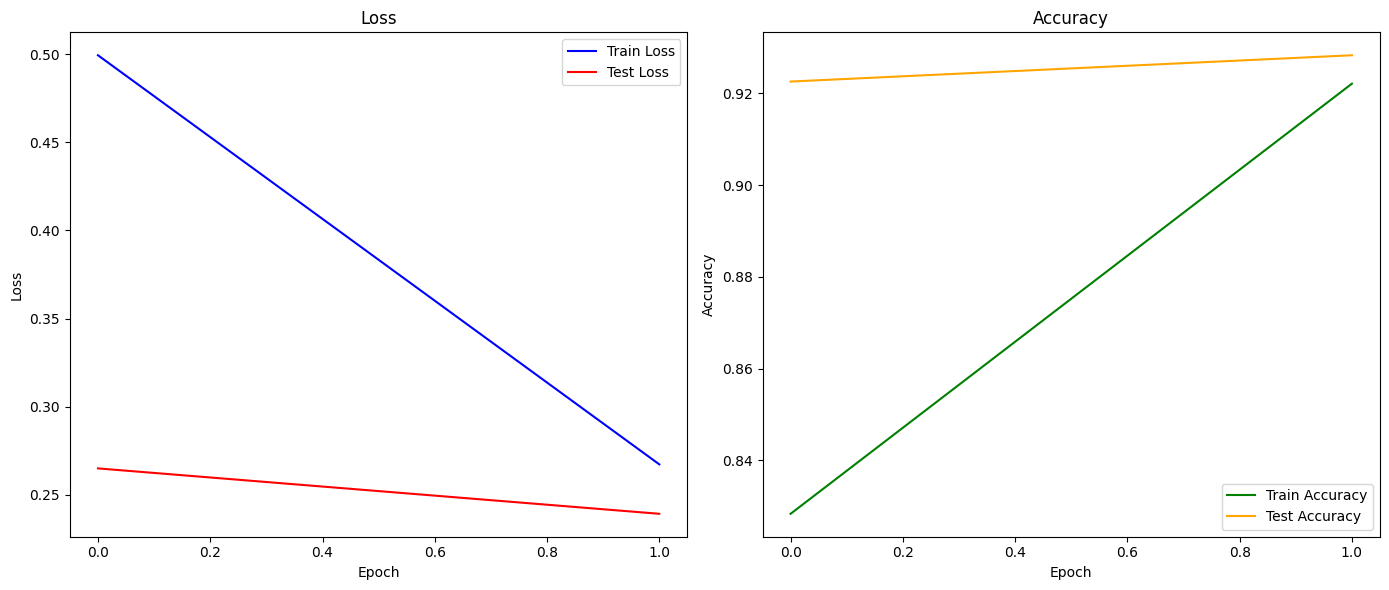

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(train_loss, label='Train Loss', color='blue')
ax1.plot(test_loss, label='Test Loss', color='red')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting train and test accuracy on the second subplot
ax2.plot(train_acc, label='Train Accuracy', color='green')
ax2.plot(test_acc, label='Test Accuracy', color='orange')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [45]:
# Create a DataFrame for all epoch predictions and true labels

df_results = pd.DataFrame({"Predictions": all_epoch_preds, "True Labels": all_epoch_labels})


Print the classification report

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2946
           1       0.93      0.97      0.95      2722
           2       0.93      0.88      0.90      2518
           3       0.91      0.92      0.92      5070

    accuracy                           0.93     13256
   macro avg       0.93      0.92      0.93     13256
weighted avg       0.93      0.93      0.93     13256



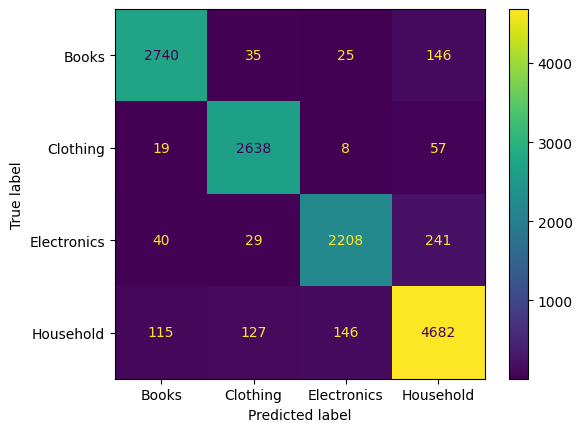

In [46]:
y_pred = df_results['Predictions']
y_true = df_results['True Labels']

# Generate classification report
report = classification_report(y_true, y_pred)

print(report)

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=['Books','Clothing','Electronics','Household']).plot()